# MapReduce using SPARK

In [1]:
import os
# needed to get this to work 
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk1.8.0_172.jdk/Contents/Home'

In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


# Table of Contents

* [SPARK](#SPARK)
    * Installing Spark locally
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count 1](#word-count-1)
    * [word count 2:  `reduceByKey()`](#word-count-2:--reduceByKey%28%29)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)
    * [Machine Learning](#Machine-Learning)


With shameless stealing of some code and text from:

- https://github.com/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb
- Databricks and Berkeley Spark MOOC: https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x

which you should go check out.

# Spark Context

You can also use it directly from the notebook interface on the mac if you installed `apache-spark` using `brew` and also installed `findspark` above.

In [3]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [4]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

In [6]:
import random
num_samples = 100000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.141352


### Create A RDD


In [7]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print (type(wordsRDD))

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

In [8]:
wordsRDD.collect()

['cat', 'elephant', 'rat', 'rat', 'cat']

### Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [10]:
def makePlural(word):
    return word + 's'

print(makePlural('cat'))

cats


Transform one RDD into another.

In [12]:
pluralRDD = wordsRDD.map(makePlural)
print(pluralRDD.first())
print(pluralRDD.take(2))


cats
['cats', 'elephants']


In [13]:
pluralRDD.take(1)

['cats']

In [14]:
pluralRDD.collect()

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [16]:
wordPairs = wordsRDD.map(lambda w: (w, 1))
print(wordPairs.collect())

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


### WORD COUNT!

This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.

In [17]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())
print(wordCountsCollected)

[('cat', 2), ('elephant', 1), ('rat', 2)]


![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)

In [19]:
print(wordsRDD.map(lambda w: (w, 1)).reduceByKey(lambda x,y: x+y))

PythonRDD[26] at RDD at PythonRDD.scala:48


### Using Cache

In [20]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print(wordsRDD)
wordsRDD.count()

ParallelCollectionRDD[27] at parallelize at PythonRDD.scala:175


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [21]:
#this is rerun from the start
wordsRDD.count()

5

In [22]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[27] at parallelize at PythonRDD.scala:175

In [23]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [24]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [25]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}
for e in wordsList:
    animaldict[e]='mammal'
for e in birdsList:
    animaldict[e]='bird'
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [26]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count()
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print(mammalcount, birdcount)

5 2


### Exercises: Fun with MapReduce

Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [27]:
# your turn
stopwords = pd.read_csv('./sparklect/english.stop.txt')
#sc.stop()
#sc = pyspark.SparkContext()
juliusrdd = sc.textFile('./sparklect/shakes/juliuscaesar.txt')


How many words does Julius Caesar have? *Hint: use `flatMap()`*.

In [32]:
# your turn
#counts = juliusrdd.flatMap(lambda l: l.split(' ')).map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b).collect()

wordcount = juliusrdd.flatMap(lambda l: l.split(' ')).map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b).collect()



Now print the first 20 words of Julius Caesar as a Python list.

In [33]:
# your turn
for i in range(20):
    print(wordcount[i])


('', 12571)
('him-let', 1)
('was', 57)
('So,', 2)
('Citizens,', 1)
("'tis", 13)
('matter;', 1)
('head', 2)
('dark', 1)
('avoided', 1)
('wine!', 1)
('Choose', 1)
("fear'd", 2)
('Freedom!', 1)
('choked', 2)
('According', 2)
('goes;', 1)
('USE', 5)
('benefit', 1)
("bay'd,", 1)


Now print the first 20 words of Julius Caesar, **after removing all the stopwords**. *Hint: use `filter()`*.

In [52]:
print(stopwords)

               a
0            a's
1           able
2          about
3          above
4      according
5    accordingly
6         across
7       actually
8          after
9     afterwards
10         again
11       against
12         ain't
13           all
14         allow
15        allows
16        almost
17         alone
18         along
19       already
20          also
21      although
22        always
23            am
24         among
25       amongst
26            an
27           and
28       another
29           any
..           ...
540        whole
541         whom
542        whose
543          why
544         will
545      willing
546         wish
547         with
548       within
549      without
550        won't
551       wonder
552        would
553        would
554     wouldn't
555            x
556            y
557          yes
558          yet
559          you
560        you'd
561       you'll
562       you're
563       you've
564         your
565        yours
566     yourse

In [57]:
def IsNotStopWord(w):
    wordlist=[]
    wordlist.append(w)
    if (w == u'') | (w == u'a'):   # handle NL and 'a' as a special case
        return False
    return(~any(stopwords.isin(wordlist)))

In [58]:
# your turn

wordcount = (juliusrdd
        .flatMap(lambda l: l.lower().split(' '))
        .map(lambda w: w.strip(".").strip(",").strip('"').strip("'"))

        .filter(lambda w: IsNotStopWord(w))
        .map(lambda w: (w,1))
        .reduceByKey(lambda a,b: a+b)
        .collect())

for i in range(20):
    print(wordcount[i])




('him-let', 1)
('fire!', 1)
('matter;', 1)
('head', 4)
('dark', 1)
('avoided', 1)
('swore', 2)
("fear'd", 2)
('choked', 2)
('tents', 2)
('ye', 9)
('hart', 2)
('cares', 1)
('law', 1)
('behold', 4)
('proof', 3)
('chanced', 4)
('pluck', 4)
('pindarus', 17)
('fall', 10)


Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form `(word, count)`. *Hint: use `takeOrdered()` instead of `take()`*

In [59]:
# your turn

wordcounts = (juliusrdd
        .flatMap(lambda l: l.lower().split(' '))
        .map(lambda w: w.strip(".").strip(",").strip('"').strip("'"))
        .filter(lambda w: IsNotStopWord(w))
        .map(lambda w: (w,1))
        .reduceByKey(lambda a,b: a+b))
top20 = wordcounts.takeOrdered(20, key = lambda x: -x[1])



Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

In [67]:
df = pd.DataFrame(top20)
df.head()

,0,1
0,brutus,355
1,cassius,218
2,caesar,205
3,antony,123
4,thou,112


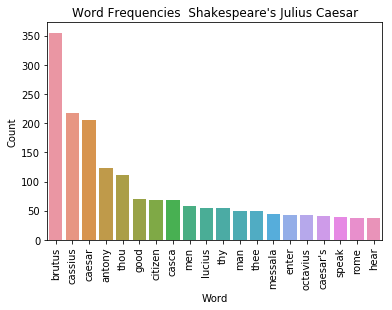

In [70]:

ax = sns.barplot(data=df,x=0, y=1)
ax.set_title('Word Frequencies  Shakespeare\'s Julius Caesar')
ax.set(xlabel='Word', ylabel='Count')
plt.xticks(rotation=90)
plt.show()


### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [71]:
shakesrdd=sc.textFile("./sparklect/shakes/*.txt", minPartitions=4)

In [72]:
shakesrdd.take(10)

['1601',
 'AS YOU LIKE IT',
 '',
 'by William Shakespeare',
 '',
 '',
 '',
 'DRAMATIS PERSONAE.',
 '',
 '']

Now calculate the top 20 words in all of the files that you just read.

In [73]:
# your turn
wordcounts = (shakesrdd
        .flatMap(lambda l: l.lower().split(' '))
        .map(lambda w: w.strip(".").strip(",").strip('"').strip("'"))
        .filter(lambda w: IsNotStopWord(w))
        .map(lambda w: (w,1))
        .reduceByKey(lambda a,b: a+b))
top20 = wordcounts.takeOrdered(20, key = lambda x: -x[1])
df = pd.DataFrame(top20)
df.head()

,0,1
0,thou,2093
1,thy,1548
2,good,1173
3,thee,1112
4,sir,1103


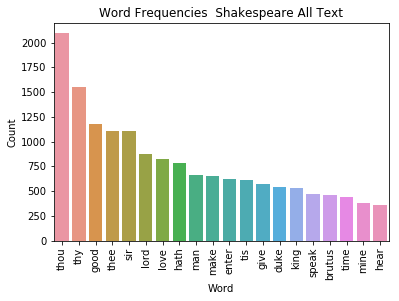

In [75]:

ax = sns.barplot(data=df,x=0, y=1)
ax.set_title('Word Frequencies  Shakespeare All Text')
ax.set(xlabel='Word', ylabel='Count')
plt.xticks(rotation=90)
plt.show()



## Optional topic 1: DataFrames

Pandas and Spark dataframes can be easily converted to each other, making it easier to work with different data formats. This section shows some examples of each.

In [76]:
df=pd.read_csv("sparklect/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Convert this pandas dataframe to a Spark dataframe

In [77]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)
sparkdf = sqlsc.createDataFrame(df)
sparkdf

DataFrame[Gender: string, Height: double, Weight: double]

In [78]:
sparkdf.show(5)

+------+-----------------+----------------+
|Gender|           Height|          Weight|
+------+-----------------+----------------+
|  Male|  73.847017017515|241.893563180437|
|  Male|68.78190404589029|  162.3104725213|
|  Male|74.11010539178491|  212.7408555565|
|  Male| 71.7309784033377|220.042470303077|
|  Male| 69.8817958611153|206.349800623871|
+------+-----------------+----------------+
only showing top 5 rows



In [80]:
type(sparkdf.Gender)

pyspark.sql.column.Column

In [81]:
# You can't call .map() on a DataFrame directly - you first have to convert it into an RDD
temp = sparkdf.rdd.map(lambda r: r.Gender)
print(type(temp))
temp.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


['Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

## Optional topic 2: Machine Learning using Spark



In [82]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

Now create a data set from the Spark dataframe

In [84]:
data=sparkdf.rdd.map(lambda row: LabeledPoint(row.Gender=='Male',[row.Height, row.Weight]))
data.take(5)

[LabeledPoint(1.0, [73.8470170175,241.89356318]),
 LabeledPoint(1.0, [68.7819040459,162.310472521]),
 LabeledPoint(1.0, [74.1101053918,212.740855557]),
 LabeledPoint(1.0, [71.7309784033,220.042470303]),
 LabeledPoint(1.0, [69.8817958611,206.349800624])]

In [85]:
data2=sparkdf.rdd.map(lambda row: LabeledPoint(row[0]=='Male',row[1:]))
data2.take(1)[0].label, data2.take(1)[0].features

(1.0, DenseVector([73.847, 241.8936]))

Split the data set into training and test sets

In [86]:
train, test = data.randomSplit([0.7,0.3])
train.cache()
test.cache()

PythonRDD[157] at RDD at PythonRDD.scala:48

In [87]:
type(train)

pyspark.rdd.PipelinedRDD

Train the logistic regression model using MLIB

In [88]:
model = LogisticRegressionWithLBFGS.train(train)

In [89]:
model.weights

DenseVector([-0.4768, 0.1961])

Run it on the test data

In [140]:
results = test.map(lambda lp: (lp.label, float(model.predict(lp.features))))
print(results.take(10))
type(results)                       

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 147.0 failed 1 times, most recent failure: Lost task 0.0 in stage 147.0 (TID 404, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-140-c93c79069485>", line 1, in <lambda>
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/mllib/classification.py", line 206, in predict
    margin = self.weights.dot(x) + self._intercept
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 372, in dot
    assert len(self) == _vector_size(other), "dimension mismatch"
AssertionError: dimension mismatch

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor193.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-140-c93c79069485>", line 1, in <lambda>
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/mllib/classification.py", line 206, in predict
    margin = self.weights.dot(x) + self._intercept
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 372, in dot
    assert len(self) == _vector_size(other), "dimension mismatch"
AssertionError: dimension mismatch

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


Measure accuracy and other metrics

In [112]:
test_accuracy=results.filter(lambda a,p: a==p).count()/float(results.count())
#test_accuracy

In [103]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(results)

In [105]:
print(type(metrics))
metrics.areaUnderROC

<class 'pyspark.mllib.evaluation.BinaryClassificationMetrics'>


0.9278202755163886

In [106]:
type(model)

pyspark.mllib.classification.LogisticRegressionModel

In [107]:
!rm -rf mylogistic.model

In [108]:
model.save(sc, "mylogistic.model")

The pipeline API automates a lot of this stuff, allowing us to work directly on dataframes.

`rdd.saveAsTextFile()` saves an RDD as a string.

## Optional Topic 3: Your Turn at Machine Learning! :)

For this exercise, we're going to use one of the datasets we've already worked with: the Boston House Prices dataset. We're going to try a couple of regression algorithms, but from the SparkML library this time.

Before you proceed, make sure to do an overview of the documentation: 
http://spark.apache.org/docs/latest/api/python/pyspark.ml.html

In [ ]:
# All imports go here




First, we have to load the dataset, which resides as a CSV file in the folder for this exercise.

In [109]:
# Path: /sparklect/boston.csv
bdf=pd.read_csv("sparklect/boston.csv")
bdf.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Inspect the data to make sure everything is loaded properly.

In [110]:
#sqlsc=SQLContext(sc)
bsparkdf = sqlsc.createDataFrame(bdf)
bsparkdf

DataFrame[crim: double, zn: double, indus: double, chas: bigint, nox: double, rm: double, age: double, dis: double, rad: bigint, tax: bigint, ptratio: double, black: double, lstat: double, medv: double]

Now we'll need to create a train/test split.

In [111]:
bsparkdf.show(5)

+--------------------+----+-----+----+-------------------+------------------+-----+------+---+---+-------+------+-----+----+
|                crim|  zn|indus|chas|                nox|                rm|  age|   dis|rad|tax|ptratio| black|lstat|medv|
+--------------------+----+-----+----+-------------------+------------------+-----+------+---+---+-------+------+-----+----+
|             0.00632|18.0| 2.31|   0| 0.5379999999999999|             6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|             0.02731| 0.0| 7.07|   0|              0.469|             6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|             0.02729| 0.0| 7.07|   0|              0.469|             7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.032369999999999996| 0.0| 2.18|   0|0.45799999999999996| 6.997999999999999| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|             0.06905| 0.0| 2.18|   0|0.45799999999999996|             7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|


In [113]:
# We'll first have to vectorize the features
pricing = bsparkdf.rdd.map(lambda r: r.medv)
print(type(pricing))
pricing.take(10)

<class 'pyspark.rdd.PipelinedRDD'>


[24.0, 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9]

In [115]:

data=bsparkdf.rdd.map(lambda r: LabeledPoint(r.medv,[r.crim, r.zn,r.indus,r.chas,r.nox,r.rm,r.age,r.dis,r.rad,r.tax,r.ptratio,r.lstat]))
data.take(5)

[LabeledPoint(24.0, [0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,4.98]),
 LabeledPoint(21.6, [0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14]),
 LabeledPoint(34.7, [0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03]),
 LabeledPoint(33.4, [0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94]),
 LabeledPoint(36.2, [0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33])]

As the next step, fit a Linear Regression model on the training set.

In [116]:
train, test = data.randomSplit([0.7,0.3])
train.cache()
test.cache()

PythonRDD[252] at RDD at PythonRDD.scala:48

In [ ]:
lrm = LinearRegressionWithSGD.train(sc.parallelize(data), iterations=10
...     initialWeights=np.array([1.0]))
>>> abs(lrm.predict(np.array([0.0])) - 0) < 0.5
True
>>> abs(lrm.predict(np.array([1.0])) - 1) < 0.5

In [127]:

from pyspark.mllib.regression import LinearRegressionWithSGD
lrm = LinearRegressionWithSGD.train(train, iterations=10, step=0.1)
#lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

Now validate the model on the test set, and check the Root Mean Squared Error.

In [156]:
results = test.map(lambda lp: (lp.label, float(lrm.predict(lp.features))))
print(results.take(10))
type(results)               

[(34.7, -5.58410498067677e+40), (21.7, -7.045037433418534e+40), (13.6, -7.1630638256302345e+40), (15.6, -7.146288192713833e+40), (13.9, -7.117460565796236e+40), (16.6, -7.13223368388286e+40), (18.4, -7.145222520405285e+40), (13.2, -7.1121956497814e+40), (20.0, -6.409218682795631e+40), (24.7, -5.200035999096695e+40)]


pyspark.rdd.PipelinedRDD

In [157]:

SE = results.map(lambda vp: (vp[0] - vp[1])**2).reduce(lambda x, y: x + y)
print("Mean Squared Error = " + str(MSE/results.count()))
#print(results.count())

Mean Squared Error = 1.0251912952906833e+82
156


Let's compare Linear Regression with a more powerful algorithm - the Random Forest. As the Random Forest has several hyperparameters that can be tuned for maximum accuracy, we're going to need to use k-fold Cross Validation.

First, set up a grid for the hyperparameter search.

In [170]:
pred_lr = lrm.predict(test.map(lambda x: x.features))
testresults = test.map(lambda lp: lp.label).zip(pred_lr)
testMSE = testresults.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(test.count())
print('Test Mean Squared Error = ' + str(testMSE))

Test Mean Squared Error = 1.02519129529e+82


In [150]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

Now, with a Random Forest regressor using k-fold Cross Validation, and find the optimal combination of hyperparameters.

In [164]:
rfm = RandomForest.trainRegressor(train,categoricalFeaturesInfo={}, numTrees=3, maxDepth=4, maxBins=32)


Finally, validate the model on the test set and check the Root Mean Squared Error again.

In [168]:
# Evaluate model on test instances and compute test error
pred = rfm.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(pred)
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(test.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression forest model:')
print(rfm.toDebugString())

Test Mean Squared Error = 17.890009790547364
Learned regression forest model:
TreeEnsembleModel regressor with 3 trees

  Tree 0:
    If (feature 9 <= 264.5)
     If (feature 5 <= 6.5115)
      If (feature 10 <= 18.95)
       If (feature 11 <= 7.41)
        Predict: 27.924999999999997
       Else (feature 11 > 7.41)
        Predict: 21.34444444444444
      Else (feature 10 > 18.95)
       If (feature 0 <= 0.101185)
        Predict: 19.740000000000002
       Else (feature 0 > 0.101185)
        Predict: 16.499999999999993
     Else (feature 5 > 6.5115)
      If (feature 5 <= 7.3725000000000005)
       If (feature 11 <= 4.475)
        Predict: 31.525
       Else (feature 11 > 4.475)
        Predict: 34.48695652173913
      Else (feature 5 > 7.3725000000000005)
       If (feature 11 <= 4.475)
        Predict: 46.9
       Else (feature 11 > 4.475)
        Predict: 35.19999999999999
    Else (feature 9 > 264.5)
     If (feature 5 <= 7.005999999999999)
      If (feature 11 <= 14.115)
       I

In [ ]:
# Stop Spark
sc.stop()